In [60]:
using QuantumOptics
using Statistics
using PyPlot
using JLD2
using CollectiveSpins

# MPC computations, variable angle of the laser

### Functions

In [61]:
function avgSz(rho)
    Sz = [CollectiveSpins.mpc.sz(ρ) for ρ in rho]
    meanSz = [mean(subarray) for subarray in Sz]
    return meanSz
end

function calcEvolutionMPC(λl, θl, Tstep, Tend, theta, phi)
    a,b,c = [d_xy,d_xy,d_z]/λl
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)

    theta_array = ones(N)*theta
    phi_array = prepare_phi_IS(θl, λl, theta_array, phi, system)
    Ψ0 = CollectiveSpins.mpc.blochstate(phi_array, theta_array)

    tout, ρt = CollectiveSpins.mpc.timeevolution(T, system, Ψ0, dt=Tstep)
    meanSz = avgSz(ρt)
    return meanSz
end

function calcSE_MPC(Tstep, Tend, phi, theta)
    a,b,c = [266.,266.,532.]
    geometry = CollectiveSpins.geometry.box(a,b,c;Nx=Nx,Ny=Ny,Nz=Nz)
    e = [0,0,1]   # Quantization axis
    system = CollectiveSpins.SpinCollection(geometry, e, gammas=1.)
    
    Ψ0 = CollectiveSpins.independent.blochstate(phi, theta, N)
    tout, ρt_ind = CollectiveSpins.independent.timeevolution(T, system, Ψ0, dt=Tstep)
    Sz = [CollectiveSpins.independent.sz(ρ) for ρ in ρt_ind]
    meanSz_ind = [mean(subarray) for subarray in Sz]
    return meanSz_ind
end

""" Prepare the initial state of the system 
with a phase correlation imposed between the atoms
because the laser arrive on the lattice with an angle θl """
function prepare_phi_IS(θl, λl, theta_array, phi, system)
    phi_array = zeros(N)
    for i = 1:N
        phi_array[i] = 2pi * sqrt(sum((system.spins[i].position .* [cos(θl), sin(θl), 0]) .^ 2)) + phi
    end
    return phi_array
end

prepare_phi_IS

### Define the system

In [62]:
# Define geometry of system
Nx,Ny,Nz = [5,5,3] #5x5x3=75 sites takes about 6 seconds to calculate on my laptop (first time is slower ofcourse)
N = Nx*Ny*Nz

# Prepare the initial state: first atom hit by a laser
phi = 0.
theta = π/2
d_xy, d_z = 266., 532.

# Define computation variables
Tstep, Tend = 0.05, 0.05
T = [0:Tstep:Tend;]
Lambda_array = [583, 631, 841, 1299]
num_points_per_lambda = 1000

θl_array = range(0, 2π, length=num_points_per_lambda);

### Computations

In [63]:
# Compute Spontaneous emission diff at t=0
diff_meanSz_SE_t0 = diff(calcSE_MPC(Tstep, Tend, phi, theta))[1]/Tstep;

In [64]:
# Prepare matrix for all lambda and all d
norm_diff_meanSz_t0 = zeros(size(Lambda_array)[1], num_points_per_lambda)

for i in 1:size(Lambda_array)[1]
    println(string(i)*"/"*string(size(Lambda_array)[1]))
    for j in 1:size(θl_array)[1]
        norm_diff_meanSz_t0[i,j] = (diff(calcEvolutionMPC(Lambda_array[i], θl_array[j], Tstep, Tend, theta, phi))[1]/Tstep)/diff_meanSz_SE_t0
    end
end

1/4
2/4
3/4
4/4


# Plots

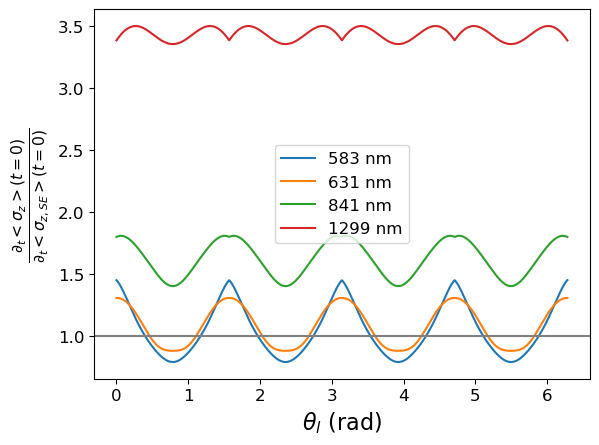

In [ ]:
close("all")
figure()

PyPlot.rc("font", size = 12)

# Plot
for i in 1:size(Lambda_array)[1]
    plot(θl_array, norm_diff_meanSz_t0[i,:], label=string(Lambda_array[i])*" nm")
end

axhline(1, color="grey")
xlabel(L"$\theta_l$ (rad)", fontsize=16)
ylabel(L"\frac{\partial_t<\sigma_z>(t=0)}{\partial_t<\sigma_{z, SE}>(t=0)}", fontsize=16)
legend()

#savefig("/Users/remy/Documents/Remy/ENSL_2024_2025/Stage_M2/Rapport_Stage_M2/Figures/SR_criterium(theta_l).pdf", bbox_inches="tight")

pygui(false); gcf()

In [ ]:
# Save data
#save_object("Initial_Slope_Hor(theta_l).jld2", norm_diff_meanSz_t0);

In [67]:
# Load data
norm_diff_meanSz_t0 = load_object("Initial_Slope_Hor(theta_l).jld2");